# LDA Mallet Topic Modeling -- European Folktales

CS72/LING48 Spring 2022 Final Project

**Author:** Zhiyan Zhong (zhiyan.zhong.gr@dartmouth.edu) <br>
**Date:** 6/6/2022 <br>
**Description:** This program is one of our two topic modeling methods used in our final project. It uses the LDA Mallet model to extract topics from 250 European folktales and then create graphs for better visualization.<br>
**References:**
- https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda
- https://medium.com/@kurtsenol21/topic-modeling-lda-mallet-implementation-in-python-part-1-c493a5297ad2
- https://medium.com/swlh/topic-modeling-lda-mallet-implementation-in-python-part-2-602ffb38d396


# Preparation



## Install and import necessary libraries

In [1]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 4.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=62fc02c71e1220e48a3472c27050203c72da8f2ffc7c2798cfbf0ddc4072c25c
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

# NLTK library and download stopwords for data cleanning
import nltk 
nltk.download('stopwords')

# Spacy for lemmatization
import spacy

# Gensim libraries for preprocessing and building the model
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Visualization tools
import pyLDAvis
import pyLDAvis.gensim_models

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


Mounted at /content/drive


## Download the data set

In [3]:
import gdown
url = "https://drive.google.com/uc?id=1bS7Tqz3JlGCMvrDGn4Yq2IqaGMlrHCPc"
output = 'europe.csv'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1bS7Tqz3JlGCMvrDGn4Yq2IqaGMlrHCPc
To: /content/europe.csv
100%|██████████| 3.03M/3.03M [00:00<00:00, 134MB/s]


'europe.csv'

In [4]:
df = pd.read_csv('europe.csv')

In [5]:
df

,Region,Country/Area,Text
0,Europe,England,"Once upon a time there was a woman, and she ba..."
1,Europe,England,Once upon a time there was a farmer and his wi...
2,Europe,England,There was once upon a time a good man who had ...
3,Europe,England,"An old woman was sweeping her house, and she f..."
4,Europe,England,"Once on a time there was a boy named Jack, and..."
...,...,...,...
245,Europe,Russia,"Long ago there lived a King, and he had three ..."
246,Europe,Russia,"One evening, when they were sitting round the ..."
247,Europe,Russia,This chapter is not one of old Peter's stories...
248,Europe,Russia,"In an old, old Russian tsarstvo, I do not know..."


# Preprocessing

This process includes tokenization, lemmatization, n-grams implementation, and speech of tag selection.

In [6]:
# Convert folktales' text to a list of strings
data = list(df.Text)

In [7]:
stop_words = nltk.corpus.stopwords.words('english')

In [8]:
# Build the bigram and trigrams
bigram = gensim.models.Phrases(data, min_count=20, threshold=100) 
trigram = gensim.models.Phrases(bigram[data], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [9]:
# We only need tagger without parser and named entity recognizer here for faster implementation
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


In [10]:
# Define a function to convert data into a list of lowercase tokens, build bigrams-trigrams, and implement lemmatization

def data_preprocessing(texts, stop_words=stop_words, allowed_tags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    
    # remove stopwords, short tokens and letter accents 
    texts = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts]
    
    # bi-gram and tri-gram implementation
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    
    text_output = []

    # implement lemmatization and filter out unwanted part of speech tags
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        text_output.append([token.lemma_ for token in doc if token.pos_ in allowed_tags])
    
    # remove stopwords and short tokens again after lemmatization
    text_output = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in text_output]    
    
    return text_output

In [11]:
# Call the above function to process the data
data_processed = data_preprocessing(data) 

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use sele

In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_processed)

# Create corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_processed]

print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 8695


In [13]:
# Create a dictionary and convert it to a dataframe to shows each word in the corpus and their frequency
dict_corpus = {}

for i in range(len(corpus)):
  for idx, freq in corpus[i]:
    if id2word[idx] in dict_corpus:
      dict_corpus[id2word[idx]] += freq
    else:
       dict_corpus[id2word[idx]] = freq

dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['frequency'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


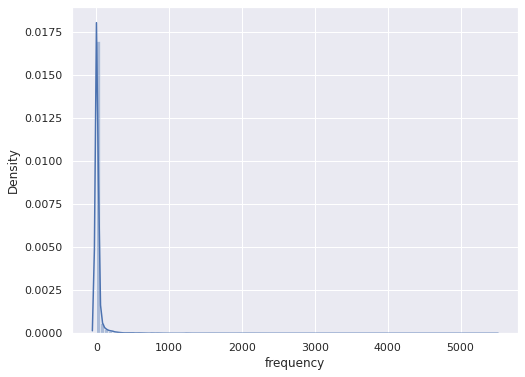

In [14]:
# Visualize the word frequencies to better understand the corpus
plt.figure(figsize=(8,6))
sns.distplot(dict_df['frequency'], bins=100);

From the graph above, we can see that some words have higher frequencies than the majority. Therefore, we want to know what those words are and then possibly remove them.

In [15]:
# The top 50 most frequent words
dict_df.sort_values('frequency', ascending=False).head(50)

,frequency
say,5461
come,3120
see,2560
little,2027
take,1932
man,1710
old,1581
give,1532
would,1436
make,1414


Since msot of these high-frequency words don't seem to matter when it comes to topic modeling. We will set a threshold to filter out high-frequency words.

In [16]:
extension = dict_df[dict_df.frequency>500].index.tolist()

# include these additional words in stopwords
stop_words.extend(extension)

# call the previously defined "data_preprocessing" function again to remove the newly added stopwords
data_processed = data_preprocessing(data)

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use sele

In [17]:
# Create vocab dictionary
id2word = corpora.Dictionary(data_processed)

print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 8607


In [18]:
# Filter out extreme words
# Here we decide to filter out words that occur in less than 5 folktales, or more than 80% of the folktales.

id2word.filter_extremes(no_below=5, no_above=0.8)

print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 2801


In [19]:
# Create the current corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_processed]

# Model Building

## LDA Mallet

In [20]:
# Install Mallet package
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

--2022-06-07 03:13:46--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2022-06-07 03:13:47--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  6.89MB/s    in 2.2s    

2022-06-07 03:13:50 (6.89 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]



In [21]:
!unzip mallet-2.0.8.zip

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classify  
  inflating: mallet-2.0.8/bin/text2vectors  
  inflating: mallet-2.0.8/bin/vectors2classify  
  inflating: mallet-2.0.8/bin/vectors2info  
  inflating: mallet-2.0.8/bin/vectors2topics  
  inflating: mallet-2.0.8/bin/vectors2vectors  
  inflating: mallet-2.0.8/build.xml  
   creating: mallet-2.0.8/class/
   creating: mallet-2.0.8/class/cc/
   creating: mallet-2.0.8/class/cc/mallet/
   creating: mallet-2.0.8/class/cc/mallet/classify/
  inflating: mallet-2.0.8/class/cc/mallet/classify/AdaBoost.class  
  in

In [22]:
# Indicate the path to pass in LdaMallet wrapper
mallet_path = '/content/mallet-2.0.8/bin/mallet'

Since the LDA Mallet method requires users to set the number of topics they want to extract, we want to compute coherence scores for different numbers of topics to find the optimal number of topics for the model.

In [23]:
# Compute coherence score for different number of topics
# to find the optimal number of topics for the model

# Parameters:
#     dictionary : Gensim dictionary
#     corpus : Gensim corpus
#     texts : List of input texts
#     limit : Max num of topics

#     Returns:
#     model_list : List of LDA topic models
#     coherence_values : Coherence values corresponding to the LDA model with respective number of topics

def compute_coherence(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [24]:
model_list, coherence_values = compute_coherence(dictionary=id2word, corpus=corpus, texts=data_processed, start=2, limit=40, step=6)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:496: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:496: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:496: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:496: DeprecationWarning: This function is

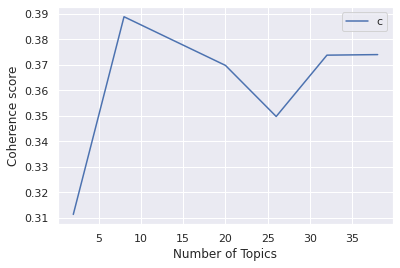

In [25]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [27]:
# Build the model for 8 topics, which is an optimal number of topics indicated in the above gragh during my run
# The optimal number of topics may change during different runs
# Therefore, the number of topics here needs to be adjusted accordingly based on the above result

ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=8, id2word=id2word)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:496: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:496: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


In [28]:
# Import pretty print for better viewing
from pprint import pprint

# Display topics and their relative weights
pprint(ldamallet.show_topics(formatted=False))

[(0,
  [('order', 0.02648120904105925),
   ('answer', 0.01852347198074094),
   ('reply', 0.014109937140564398),
   ('return', 0.013708706700548348),
   ('tsar', 0.013574963220542998),
   ('send', 0.012170656680486827),
   ('word', 0.01029824796041193),
   ('lay', 0.01016450448040658),
   ('desire', 0.01016450448040658),
   ('kingdom', 0.008693326200347733)]),
 (1,
  [('dog', 0.014746603129628437),
   ('golden', 0.01384506407366862),
   ('princess', 0.013587481486251529),
   ('mountain', 0.010947259965226351),
   ('young', 0.010818468671517806),
   ('sea', 0.009659347028140898),
   ('youth', 0.009401764440723806),
   ('tree', 0.009337368793869535),
   ('rise', 0.009272973147015261),
   ('pass', 0.008950994912743898)]),
 (2,
  [('people', 0.03209606986899563),
   ('play', 0.021688500727802037),
   ('thing', 0.021542940320232896),
   ('dance', 0.015283842794759825),
   ('talk', 0.014046579330422125),
   ('terence', 0.013973799126637555),
   ('answer', 0.012445414847161572),
   ('year', 0.

The LDA model returns only related terms and not the labels for the terms. We need to analyze the results and provide a label (topic) to each topic group.

## Compute coherence score

In [29]:
# Compute coherence score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_processed, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('Coherence Score: ', coherence_ldamallet)

Coherence Score:  0.3837068780448781


In [30]:
# Pickle the model
import pickle

example_dict = ldamallet

pickle_out = open("drive/My Drive/ldamallet.pkl", "wb")
pickle.dump(example_dict, pickle_out)
pickle_out.close()

In [31]:
ldamallet = pickle.load(open("drive/My Drive/ldamallet.pkl", "rb"))

In [32]:
tm = ldamallet[corpus[1]]

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:496: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:496: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


We can get the topic modeling results (distribution of topics for each folktale) if we pass in the corpus to the model. For the whole data set, we have the below:

In [33]:
tm_results = ldamallet[corpus]

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:496: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:496: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


In [34]:
# get the most dominant topic of each folktale
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]

To get the most probable words for the given topicid, we use show_topic() method. It returns sequence of probable words, as a list of (word, word_probability) for specific topic.

In [37]:
topics = [[(term, round(wt, 3)) for term, wt in ldamallet.show_topic(n, topn=8)] for n in range(0, ldamallet.num_topics)]

 ## Create a dataframe for term-topic matrix

In [38]:
topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], columns = ['Term'+str(i) for i in range(1, 9)],
                         index=['Topic '+str(t) for t in range(1, ldamallet.num_topics+1)]).T
topics_df.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
Term1,order,dog,people,life,wife,kill,giant,blondine
Term2,answer,golden,play,heart,fish,young,girl,violette
Term3,reply,princess,thing,love,fool,castle,eat,dear
Term4,return,mountain,dance,pass,ship,fire,tree,love
Term5,tsar,young,talk,beautiful,fly,strike,sister,enter


In [39]:
# We can also display all terms related to a topic in a row as below
pd.set_option('display.max_colwidth', -1)

topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1, ldamallet.num_topics+1)] )
topics_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Terms per Topic
Topic1,"order, answer, reply, return, tsar, send, word, lay"
Topic2,"dog, golden, princess, mountain, young, sea, youth, tree"
Topic3,"people, play, thing, dance, talk, terence, answer, year"
Topic4,"life, heart, love, pass, beautiful, set, word, carry"
Topic5,"wife, fish, fool, ship, fly, peasant, rich, set"
Topic6,"kill, young, castle, fire, strike, morning, sword, dead"
Topic7,"giant, girl, eat, tree, sister, bed, throw, black"
Topic8,"blondine, violette, dear, love, enter, hour, heart, draw"


## WordClouds

The font sizes of each word show its relative weight in the topic.

In [40]:
from wordcloud import WordCloud

# initiate wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

plt.rcParams['figure.figsize'] = [20, 15]

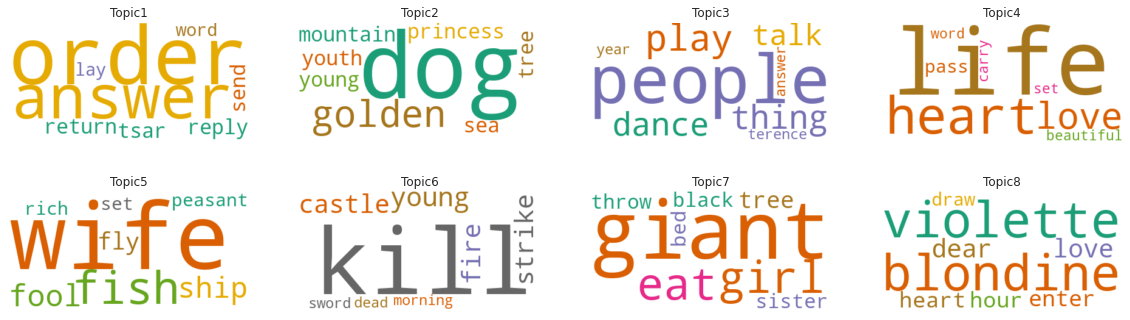

In [41]:
# Create subplots for each topic
for i in range(8):

    wc.generate(text=topics_df["Terms per Topic"][i])
    
    plt.subplot(5, 4, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

plt.show()

# More Data Visualization

## pyLDAvis

In [42]:
from gensim.models.ldamodel import LdaModel

# convert LdaMallet model to a gensim model.
def MalletToGensim(mallet_model):
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha) # original function has 'eta=0' argument
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [43]:
# call the above defined function to convert our model
ldagensim = MalletToGensim(ldamallet)

In [44]:
import pyLDAvis.gensim_models as gensimvis

data_viz = gensimvis.prepare(ldagensim, corpus, id2word, sort_topics=False)
pyLDAvis.display(data_viz)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


## Dominant topics for each folktale

In [45]:
# create a dataframe 
corpus_topic_df = pd.DataFrame()

# get the Titles from the original dataframe
# Using the country/area column here for an easier view
df.rename(columns = {'Country/Area' : 'Area'}, inplace = True)
corpus_topic_df['Area'] = df.Area

corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution Percentage'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['Topic Terms'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]

corpus_topic_df.sort_values(by=['Dominant Topic'])

,Area,Dominant Topic,Contribution Percentage,Topic Terms
249,Russia,1,32.59,"order, answer, reply, return, tsar, send, word, lay"
68,Germany,1,33.82,"order, answer, reply, return, tsar, send, word, lay"
54,Germany,1,22.65,"order, answer, reply, return, tsar, send, word, lay"
43,Germany,1,15.93,"order, answer, reply, return, tsar, send, word, lay"
111,Sweden,1,18.64,"order, answer, reply, return, tsar, send, word, lay"
...,...,...,...,...
153,France,8,27.11,"blondine, violette, dear, love, enter, hour, heart, draw"
154,France,8,35.41,"blondine, violette, dear, love, enter, hour, heart, draw"
155,France,8,39.75,"blondine, violette, dear, love, enter, hour, heart, draw"
158,France,8,51.52,"blondine, violette, dear, love, enter, hour, heart, draw"
